Processing folder 'C:/Users/Dell/Downloads/temp\1' with 20 images.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
Processing folder 'C:/Users/Dell/Downloads/temp\0' with 9 images.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━

Enter the path to the test image:  C:/Users/Dell/Downloads/nonhumanjpeg.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
Prediction: Non-Human


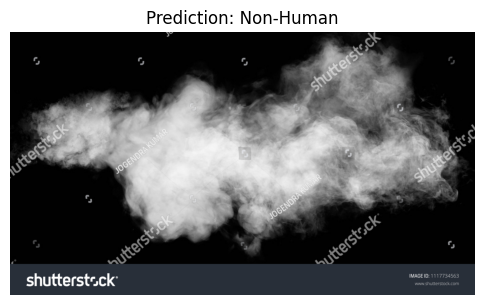

In [1]:
import os
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Feature extraction using VGG16
def extract_features_vgg16(image_path):
    # Load image and preprocess for VGG16
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Extract features using VGG16
    vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
    features = vgg_model.predict(img_array)
    return features.flatten()

# Process dataset
def process_dataset_vgg16(dataset_path):
    features = []
    labels = []
    
    for label_folder in ['1', '0']:
        folder_path = os.path.join(dataset_path, label_folder)
        image_files = glob(os.path.join(folder_path, "*.png"))
        print(f"Processing folder '{folder_path}' with {len(image_files)} images.")
        
        for image_path in image_files:
            try:
                feature = extract_features_vgg16(image_path)
                features.append(feature)
                labels.append(int(label_folder))
            except Exception as e:
                print(f"Error processing {image_path}: {e}")
    
    return np.array(features, dtype=np.float32), np.array(labels, dtype=np.int32)

# Train classifier
def train_classifier_vgg16(dataset_path):
    features, labels = process_dataset_vgg16(dataset_path)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    # Train an SVM classifier
    classifier = SVC(kernel='linear', probability=True)
    classifier.fit(X_train, y_train)
    print("Training complete.")
    
    # Evaluate the classifier
    y_pred = classifier.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    return classifier

# Test classifier
def test_classifier_vgg16(classifier, image_path):
    # Extract features and make prediction
    features = extract_features_vgg16(image_path).reshape(1, -1)
    prediction = classifier.predict(features)
    print(f"Prediction: {'Human' if prediction[0] == 1 else 'Non-Human'}")
    
    # Visualize the test image with a bounding box if it's a human
    img = cv2.imread(image_path)
    if prediction[0] == 1:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        human_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_fullbody.xml')
        
        # Detect humans
        humans = human_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))
        
        # Draw bounding boxes around detected humans
        for (x, y, w, h) in humans:
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Convert BGR image to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Plot the image with a subplot
    plt.figure(figsize=(6, 6))
    plt.subplot(1, 1, 1)
    plt.imshow(img_rgb)
    plt.title(f"Prediction: {'Human' if prediction[0] == 1 else 'Non-Human'}")
    plt.axis('off')
    plt.show()

# Main script
if __name__ == "__main__":
    dataset_path = 'C:/Users/Dell/Downloads/temp'  # Update this path to your dataset
    
    # Train the classifier
    classifier = train_classifier_vgg16(dataset_path)
    
    # Ask the user for the test image path
    test_image_path = input("Enter the path to the test image: ")
    
    try:
        # Test the classifier with the provided image
        test_classifier_vgg16(classifier, test_image_path)
    except Exception as e:
        print(f"Error testing classifier with image {test_image_path}: {e}")
